In [1]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy
from sklearn.preprocessing import StandardScaler

**Load Data**

Loads the cleaned movie overview texts and their associated genres from pickle files. These will be used as input features and target labels for the classification task.

In [2]:
with open('features/data.pkl', 'rb') as f:
    movies_clean = pickle.load(f)

with open('features/genres.pkl', 'rb') as f:
    genres = pickle.load(f)

**Device Selection**

Checks if a GPU is available and sets the computation device accordingly. Using a GPU can significantly speed up model training.

In [3]:
# Check the aviability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Custom Dataset Class**

Defines the `MovieGenreDataset` class, which wraps the features and labels into a PyTorch Dataset. It handles conversion from sparse matrices to tensors and manages multi-label binarization for the genres.

In [4]:
class MovieGenreDataset(Dataset):
    def __init__(self, X, genres, mlb=None, is_train=False):
        # Convert sparse matrix to dense tensor
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            self.features = torch.FloatTensor(X.toarray())
        else:
            self.features = torch.FloatTensor(X)
        
        # Convert genres to multi-hot encoding
        if is_train:
            self.mlb = MultiLabelBinarizer()
            self.labels = torch.FloatTensor(self.mlb.fit_transform(genres))
        elif mlb is not None:
            self.mlb = mlb
            self.labels = torch.FloatTensor(self.mlb.transform(genres))
        else:
            raise ValueError("Must provide MLBinarizer for val/test sets")
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def get_num_classes(self):
        return len(self.mlb.classes_)
    
    def get_mlb(self):
        return self.mlb


**Data Splitting and Feature Extraction**

Splits the data into training, validation, and test sets. Extracts features using TF-IDF, bigram, and trigram vectorizers, and combines them. The features are standardized, and PyTorch datasets are created for each split.

In [5]:
# First split: separate test set (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    movies_clean["cleaned_overview"], genres, test_size=0.2, random_state=42,
)

# Second split: separate train and validation from temp (0.8 * 0.8 = 64% train, 0.8 * 0.2 = 16% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42,
)

tfidf_vec = TfidfVectorizer(max_features=2000, ngram_range=(1, 3), min_df=2, max_df=0.95, sublinear_tf=True)
bigram = CountVectorizer(ngram_range=(2, 2), max_features=2000, min_df=2, max_df=0.95)
trigram = CountVectorizer(ngram_range=(3, 3), max_features=2000)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_val_tfidf = tfidf_vec.transform(X_val)
X_test_tfidf = tfidf_vec.transform(X_test)
X_train_bigram = bigram.fit_transform(X_train)
X_val_bigram = bigram.transform(X_val)
X_test_bigram = bigram.transform(X_test)
X_train_trigram = trigram.fit_transform(X_train)
X_val_trigram = trigram.transform(X_val)
X_test_trigram = trigram.transform(X_test)

# Combine TF-IDF and bigram features
X_train = hstack([
    X_train_tfidf, 
    X_train_bigram,
    X_train_trigram
])
X_val = hstack([
    X_val_tfidf, 
    X_val_bigram,
    X_val_trigram
])
X_test = hstack([
    X_test_tfidf, 
    X_test_bigram,
    X_test_trigram
])

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Create datasets for each split
train_dataset = MovieGenreDataset(X_train, y_train, is_train=True)
mlb = train_dataset.get_mlb()
val_dataset = MovieGenreDataset(X_val, y_val, mlb=mlb)
test_dataset = MovieGenreDataset(X_test, y_test, mlb=mlb)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 6380
Validation samples: 1596
Testing samples: 1995


**Genre Distribution Visualization**

Calculates and visualizes the distribution of each genre across the train, validation, and test sets. This helps ensure that the splits are balanced and representative.

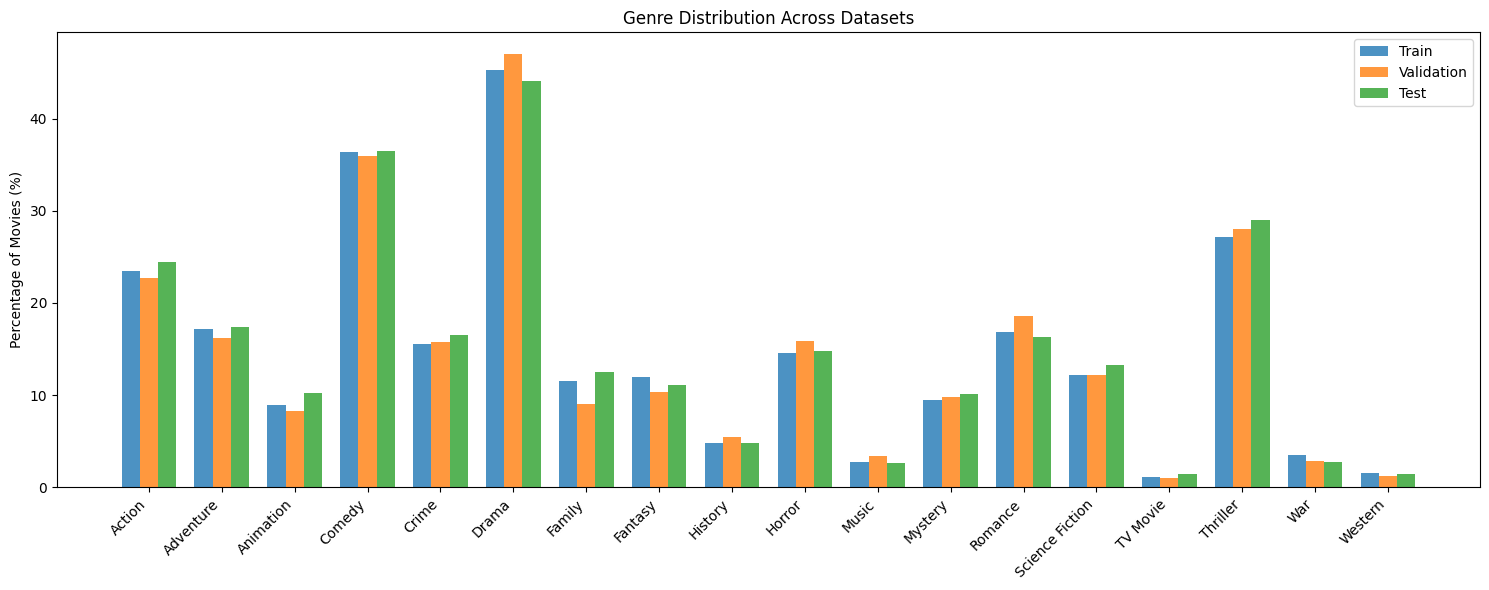


Genre distribution (%):
Genre              Train   Validation     Test
---------------------------------------------
Action             23.46        22.74    24.46
Adventure          17.15        16.23    17.39
Animation           8.95         8.27    10.28
Comedy             36.36        35.96    36.44
Crime              15.53        15.73    16.54
Drama              45.28        46.99    44.11
Family             11.57         9.02    12.53
Fantasy            11.96        10.40    11.13
History             4.80         5.45     4.86
Horror             14.53        15.85    14.79
Music               2.71         3.38     2.61
Mystery             9.53         9.77    10.13
Romance            16.83        18.55    16.34
Science Fiction    12.16        12.16    13.28
TV Movie            1.16         1.00     1.45
Thriller           27.12        28.07    29.02
War                 3.48         2.88     2.81
Western             1.60         1.25     1.50


In [6]:
import numpy as np

import matplotlib.pyplot as plt

# Get labels for each dataset
train_labels = train_dataset.labels.numpy()
val_labels = val_dataset.labels.numpy()
test_labels = test_dataset.labels.numpy()

# Calculate the percentage of each genre in each dataset
train_dist = train_labels.sum(axis=0) / len(train_labels) * 100
val_dist = val_labels.sum(axis=0) / len(val_labels) * 100
test_dist = test_labels.sum(axis=0) / len(test_labels) * 100

# Get genre names
genre_names = train_dataset.mlb.classes_

# Create a bar plot
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(len(genre_names))
width = 0.25

ax.bar(x - width, train_dist, width, label='Train', alpha=0.8)
ax.bar(x, val_dist, width, label='Validation', alpha=0.8)
ax.bar(x + width, test_dist, width, label='Test', alpha=0.8)

ax.set_ylabel('Percentage of Movies (%)')
ax.set_title('Genre Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(genre_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print exact percentages
print("\nGenre distribution (%):")
print(f"{'Genre':<15} {'Train':>8} {'Validation':>12} {'Test':>8}")
print("-" * 45)
for i, genre in enumerate(genre_names):
    print(f"{genre:<15} {train_dist[i]:8.2f} {val_dist[i]:12.2f} {test_dist[i]:8.2f}")

**Hyperparameter Setup**

Defines key hyperparameters for the model, such as input and output sizes, learning rate, dropout rate, and batch size. Also calculates positive and negative sample counts for each genre.

In [7]:
# Now set the hyperparameters with correct output_size
input_size = X_train.shape[1]
output_size = train_dataset.get_num_classes()
num_epochs = 100
learning_rate = 5e-4
weight_decay = 1e-4
dropout_rate = 0.5
hidden_size = 512
batch_size = 128
pos_counts = np.sum(train_dataset.labels.numpy(), axis=0)
neg_counts = len(train_dataset) - pos_counts

print(f"Number of features (input_size): {input_size}")
print(f"Number of genres (output_size): {output_size}")

Number of features (input_size): 6000
Number of genres (output_size): 18


**DataLoader Creation**

Creates PyTorch DataLoaders for the training, validation, and test datasets. DataLoaders handle batching and shuffling during model training and evaluation.

In [8]:
# Create dataloaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

**Model and Loss Function Definition**

Defines the feedforward neural network architecture and the custom loss function with label smoothing and class weighting. Initializes the model, loss function, optimizer, and learning rate scheduler.

In [9]:
class FeedForwardClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(FeedForwardClassifier, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate)
        )

        self.output = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output(x)

total_samples = len(y_train)

pos_weight = torch.FloatTensor(
    (train_labels.shape[0] - train_labels.sum(0)) / train_labels.sum(0)
).to(device)

class SmoothBCEWithLogitsLoss(torch.nn.Module):
    def __init__(self, smoothing=0.1, pos_weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight

    def forward(self, pred, target):
        # Apply label smoothing
        target = target * (1 - self.smoothing) + 0.5 * self.smoothing
        # Calculate BCE with logits
        return torch.nn.functional.binary_cross_entropy_with_logits(
            pred, target, pos_weight=self.pos_weight
        )

# Initialize model, loss function, and optimizer
model = FeedForwardClassifier(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = SmoothBCEWithLogitsLoss(smoothing=0.2, pos_weight=pos_weight)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8,
)

total_steps = len(train_loader) * num_epochs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)

**Training and Validation Loop**

Implements the main training loop. For each epoch, the model is trained on the training set and evaluated on the validation set. Metrics such as loss, accuracy, precision, recall, and F1 score are calculated and stored. Early stopping is used to prevent overfitting.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define early stopping parameters
patience = 7  # Number of epochs to wait before early stopping
best_val_f1 = 0  # Initialize best validation F1 score
patience_counter = 0  # Initialize patience counter

# Lists to store metrics
history = {
    'train_loss': [], 'val_loss': [],
    'train_accuracy': [], 'val_accuracy': [],
    'train_precision': [], 'val_precision': [],
    'train_recall': [], 'val_recall': [],
    'train_f1': [], 'val_f1': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    all_train_predictions = []
    all_train_targets = []
    
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_features)
        loss = criterion(logits, batch_labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # Store predictions and targets for metrics
        predictions = (torch.sigmoid(logits) > 0.5)
        all_train_predictions.append(predictions.cpu().detach())
        all_train_targets.append(batch_labels.cpu().detach())
    
    # Concatenate all batches
    train_predictions = torch.cat(all_train_predictions, dim=0).numpy()
    train_targets = torch.cat(all_train_targets, dim=0).numpy()
    
    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_predictions)
    train_precision = precision_score(train_targets, train_predictions, average='samples', zero_division=0)
    train_recall = recall_score(train_targets, train_predictions, average='samples', zero_division=0)
    train_f1 = f1_score(train_targets, train_predictions, average='samples', zero_division=0)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    all_val_predictions = []
    all_val_targets = []
    
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            logits = model(batch_features)
            loss = criterion(logits, batch_labels)
            total_val_loss += loss.item()
            
            # Store predictions and targets for metrics
            predictions = (torch.sigmoid(logits) > 0.5)
            all_val_predictions.append(predictions.cpu().detach())
            all_val_targets.append(batch_labels.cpu().detach())
    
    
    # Concatenate all batches
    val_predictions = torch.cat(all_val_predictions, dim=0).numpy()
    val_targets = torch.cat(all_val_targets, dim=0).numpy()
    
    # Calculate validation metrics
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_precision = precision_score(val_targets, val_predictions, average='samples', zero_division=0)
    val_recall = recall_score(val_targets, val_predictions, average='samples', zero_division=0)
    val_f1 = f1_score(val_targets, val_predictions, average='samples', zero_division=0)

    scheduler.step(val_f1)
    
    # Store metrics in history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)
    history['train_precision'].append(train_precision)
    history['val_precision'].append(val_precision)
    history['train_recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train - Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f}')
    print(f'Val   - Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}')
    
    # Early stopping (using F1 score instead of just loss)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_f1': best_val_f1
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

Epoch [1/100]
Train - Loss: 1.7255, Acc: 0.0000, F1: 0.2239
Val   - Loss: 1.6360, Acc: 0.0000, F1: 0.2569
Epoch [2/100]
Train - Loss: 1.5435, Acc: 0.0000, F1: 0.2773
Val   - Loss: 1.5530, Acc: 0.0000, F1: 0.2893
Epoch [3/100]
Train - Loss: 1.4793, Acc: 0.0000, F1: 0.3102
Val   - Loss: 1.5479, Acc: 0.0000, F1: 0.2957
Epoch [4/100]
Train - Loss: 1.4429, Acc: 0.0000, F1: 0.3278
Val   - Loss: 1.5394, Acc: 0.0000, F1: 0.3007
Epoch [5/100]
Train - Loss: 1.4175, Acc: 0.0000, F1: 0.3415
Val   - Loss: 1.5450, Acc: 0.0000, F1: 0.2979
Epoch [6/100]
Train - Loss: 1.3986, Acc: 0.0000, F1: 0.3489
Val   - Loss: 1.5468, Acc: 0.0000, F1: 0.2971
Epoch [7/100]
Train - Loss: 1.3827, Acc: 0.0000, F1: 0.3564
Val   - Loss: 1.5525, Acc: 0.0000, F1: 0.2987
Epoch [8/100]
Train - Loss: 1.3713, Acc: 0.0000, F1: 0.3629
Val   - Loss: 1.5540, Acc: 0.0000, F1: 0.2986
Epoch [9/100]
Train - Loss: 1.3607, Acc: 0.0000, F1: 0.3688
Val   - Loss: 1.5519, Acc: 0.0000, F1: 0.2988
Epoch [10/100]
Train - Loss: 1.3530, Acc: 0.00

**Training History Visualization**

Plots the training and validation loss and F1 score over epochs. Also prints the best F1 scores achieved during training. This helps visualize model performance and diagnose overfitting or underfitting.
Where clearly the model is having overfitting, since the model F1-score increases in training but reaches a plateau in validation.

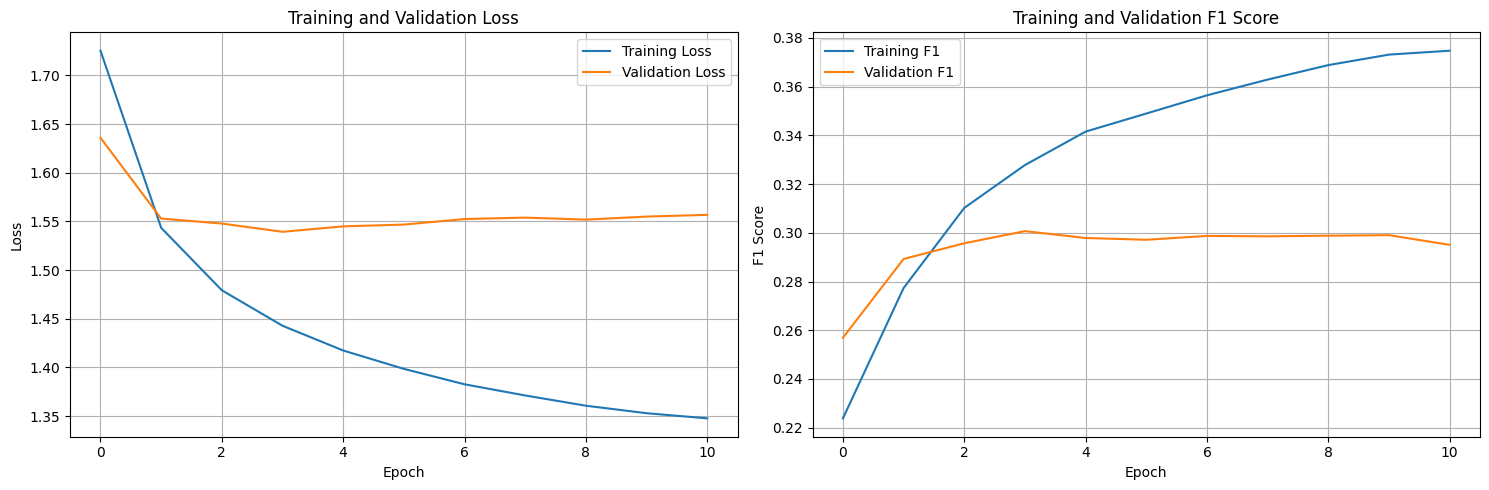

Best Training F1: 0.3747
Best Validation F1: 0.3007


In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot F1 Score
ax2.plot(history['train_f1'], label='Training F1')
ax2.plot(history['val_f1'], label='Validation F1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_title('Training and Validation F1 Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best scores
best_train_f1 = max(history['train_f1'])
best_val_f1 = max(history['val_f1'])
print(f"Best Training F1: {best_train_f1:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")

**Train/Test Split and Feature Extraction for Logistic Regression**

Performs a new train/test split and feature extraction for a logistic regression baseline. Prints the label distribution in each split and prepares the data for the baseline model.

In [12]:
import numpy as np

mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(genres)

label_counts = np.sum(y_binary, axis=0)

print("Original label distribution:")
for label, count in zip(mlb.classes_, label_counts):
    print(f"{label:<15} {count:>5}")

X_train, X_test, y_train, y_test = train_test_split(movies_clean["cleaned_overview"], y_binary, test_size=0.2, random_state=42)

print("\nLabel distribution (%):")
print(f"{'Label':<15} {'Train':>8} {'Test':>8}")
print("-" * 35)

train_dist = np.mean(y_train, axis=0) * 100
test_dist = np.mean(y_test, axis=0) * 100

for i, label in enumerate(mlb.classes_):
    print(f"{label:<15} {train_dist[i]:8.2f} {test_dist[i]:8.2f}")

tfidf_vec = TfidfVectorizer(max_features=2000, ngram_range=(1, 3), min_df=2, max_df=0.95, sublinear_tf=True)
bigram = CountVectorizer(ngram_range=(2, 2), max_features=2000, min_df=2, max_df=0.95)
trigram = CountVectorizer(ngram_range=(3, 3), max_features=2000)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)
X_train_bigram = bigram.fit_transform(X_train)
X_test_bigram = bigram.transform(X_test)
X_train_trigram = trigram.fit_transform(X_train)
X_test_trigram = trigram.transform(X_test)

X_train = hstack([
    X_train_tfidf, 
    X_train_bigram,
    X_train_trigram
])
X_test = hstack([
    X_test_tfidf, 
    X_test_bigram,
    X_test_trigram
])

train_dataset = MovieGenreDataset(X_train, y_train, is_train=True)
mlb = train_dataset.get_mlb()
test_dataset = MovieGenreDataset(X_test, y_test, mlb=mlb)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Original label distribution:
Action           2348
Adventure        1700
Animation         908
Comedy           3621
Crime            1572
Drama            4519
Family           1132
Fantasy          1151
History           490
Horror           1475
Music             279
Mystery           966
Romance          1696
Science Fiction  1235
TV Movie          119
Thriller         2757
War               324
Western           152

Label distribution (%):
Label              Train     Test
-----------------------------------
Action             23.32    24.46
Adventure          16.96    17.39
Animation           8.81    10.28
Comedy             36.28    36.44
Crime              15.57    16.54
Drama              45.62    44.11
Family             11.06    12.53
Fantasy            11.65    11.13
History             4.93     4.86
Horror             14.79    14.79
Music               2.85     2.61
Mystery             9.58    10.13
Romance            17.18    16.34
Science Fiction    12.16    13.28
TV M

**Logistic Regression Baseline**

Trains a multi-label logistic regression model as a baseline. Filters out genres with only one class in the training set to avoid errors. Evaluates and prints precision, recall, and F1-score for both training and validation sets.
Here can be seen exactly the same problem as using NN, we do have an overfitting.

In [13]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

# Find columns (genres) with more than one class in the training set
train_labels = train_dataset.labels.numpy()
valid_cols = [i for i in range(train_labels.shape[1]) if len(np.unique(train_labels[:, i])) > 1]

# Filter training and validation labels to keep only valid columns
X_train_valid = X_train.toarray()
X_val_valid = X_val.toarray()
y_train_valid = train_labels[:, valid_cols]
y_val_valid = val_dataset.labels.numpy()[:, valid_cols]

# Create and train the model only on valid columns
lr_model = MultiOutputClassifier(
	LogisticRegression(
		max_iter=1000, C=0.2, solver='liblinear', penalty='l2', class_weight='balanced'
	)
)
lr_model.fit(X_train_valid, y_train_valid)

# Make predictions on train and validation sets
train_pred = lr_model.predict(X_train_valid)
val_pred = lr_model.predict(X_val_valid)

# Calculate metrics for training set
train_precision = precision_score(y_train_valid, train_pred, average='micro')
train_recall = recall_score(y_train_valid, train_pred, average='micro')
train_f1 = f1_score(y_train_valid, train_pred, average='micro')

# Calculate metrics for validation set
val_precision = precision_score(y_val_valid, val_pred, average='micro')
val_recall = recall_score(y_val_valid, val_pred, average='micro')
val_f1 = f1_score(y_val_valid, val_pred, average='micro')

print("Training Metrics:")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_f1:.4f}")
print("\nValidation Metrics:")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

Training Metrics:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Validation Metrics:
Precision: 0.2538
Recall: 0.2538
F1-score: 0.2538
